In [1]:
!pip install -q --upgrade git+https://github.com/huggingface/transformers.git

In [2]:
!pip install -q datasets lightning

In [3]:
!pip install -q peft accelerate bitsandbytes

In [4]:
!pip install -q --upgrade wandb

## Define variables


In [5]:
REPO_ID = "google/paligemma-3b-pt-224"
FINETUNED_MODEL_ID = "Mohit1Kulkarni/paligemma-cord-demo"
MAX_LENGTH = 512
WANDB_PROJECT = "paligemma"
WANDB_NAME = "cord-demo"

In [6]:
from datasets import load_dataset

dataset = load_dataset("naver-clova-ix/cord-v2")

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Let's check out the dataset:

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 100
    })
})

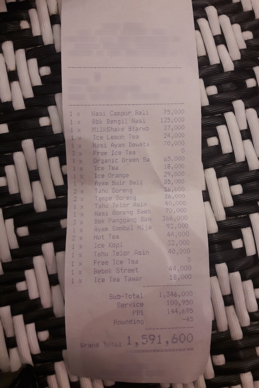

In [8]:
example = dataset['train'][0]
image = example["image"]

In [9]:
import json

ground_truth = json.loads(example["ground_truth"])
ground_truth["gt_parse"]

{'menu': [{'nm': 'Nasi Campur Bali', 'cnt': '1 x', 'price': '75,000'},
  {'nm': 'Bbk Bengil Nasi', 'cnt': '1 x', 'price': '125,000'},
  {'nm': 'MilkShake Starwb', 'cnt': '1 x', 'price': '37,000'},
  {'nm': 'Ice Lemon Tea', 'cnt': '1 x', 'price': '24,000'},
  {'nm': 'Nasi Ayam Dewata', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Free Ice Tea', 'cnt': '3 x', 'price': '0'},
  {'nm': 'Organic Green Sa', 'cnt': '1 x', 'price': '65,000'},
  {'nm': 'Ice Tea', 'cnt': '1 x', 'price': '18,000'},
  {'nm': 'Ice Orange', 'cnt': '1 x', 'price': '29,000'},
  {'nm': 'Ayam Suir Bali', 'cnt': '1 x', 'price': '85,000'},
  {'nm': 'Tahu Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tempe Goreng', 'cnt': '2 x', 'price': '36,000'},
  {'nm': 'Tahu Telor Asin', 'cnt': '1 x', 'price': '40,000.'},
  {'nm': 'Nasi Goreng Samb', 'cnt': '1 x', 'price': '70,000'},
  {'nm': 'Bbk Panggang Sam', 'cnt': '3 x', 'price': '366,000'},
  {'nm': 'Ayam Sambal Hija', 'cnt': '1 x', 'price': '92,000'},
  {'nm': 'Hot Tea', '

This is what we want the model to learn given an image.

## Create PyTorch datasets


In [10]:
from torch.utils.data import Dataset
from typing import Any, List, Dict
import random
import json


class CustomDataset(Dataset):
    """
    PyTorch Dataset. This class takes a HuggingFace Dataset as input.

    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt).
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        split: str = "train",
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.split = split
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        sort_json_key=self.sort_json_key,
                    )
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

    def json2token(self, obj: Any, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            return obj

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Dict:
        """
        Returns one item of the dataset.

        Returns:
            image : the original Receipt image
            target_sequence : tokenized ground truth sequence
        """
        sample = self.dataset[idx]

        # inputs
        image = sample["image"]
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1

        return image, target_sequence

In [11]:
train_dataset = CustomDataset("naver-clova-ix/cord-v2", split="train")
val_dataset = CustomDataset("naver-clova-ix/cord-v2", split="validation")

In [12]:
# prompt: hugging face login

from huggingface_hub import notebook_login

notebook_login()

In [13]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(REPO_ID)

2024-06-22 09:26:30.509748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 09:26:30.509889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 09:26:30.639714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

In [14]:
from torch.utils.data import DataLoader

PROMPT = "extract JSON."

def train_collate_fn(examples):
  images = [example[0] for example in examples]
  texts = [PROMPT for _ in range(len(images))]
  labels = [example[1] for example in examples]

  inputs = processor(text=texts, images=images, suffix=labels, return_tensors="pt", padding=True,
                     truncation="only_second", max_length=MAX_LENGTH,
                     tokenize_newline_separately=False)

  input_ids = inputs["input_ids"]
  token_type_ids = inputs["token_type_ids"]
  attention_mask = inputs["attention_mask"]
  pixel_values = inputs["pixel_values"]
  labels = inputs["labels"]

  return input_ids, token_type_ids, attention_mask, pixel_values, labels


def eval_collate_fn(examples):
  images = [example[0] for example in examples]
  texts = [PROMPT for _ in range(len(images))]
  answers = [example[1] for example in examples]

  inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, tokenize_newline_separately=False)

  input_ids = inputs["input_ids"]
  attention_mask = inputs["attention_mask"]
  pixel_values = inputs["pixel_values"]

  return input_ids, attention_mask, pixel_values, answers

In [15]:
train_dataloader = DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=2, shuffle=True)
input_ids, token_type_ids, attention_mask, pixel_values, labels = next(iter(train_dataloader))

In [16]:
processor.batch_decode(input_ids)

['<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><i

Let's check the corresponding labels:

In [17]:
for id, label in zip(input_ids[0][-30:], labels[0][-30:]):
  print(processor.decode([id.item()]), processor.decode([label.item()]))

s s
_ _
nm nm
> >
CAR CAR
AM AM
EL EL
AL AL
MOND MOND
</ </
s s
_ _
nm nm
>< ><
s s
_ _
cnt cnt
> >
1 1
 x  x
</ </
s s
_ _
cnt cnt
></ ></
s s
_ _
menu menu
> >
<eos> <eos>


We can do the same for the validation collate function:

In [18]:
val_dataloader = DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=2, shuffle=False)
input_ids, attention_mask, pixel_values, answers = next(iter(val_dataloader))

In [19]:
processor.batch_decode(input_ids)

['<image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><ima

In [20]:
import lightning as L
import torch
from torch.utils.data import DataLoader
import re
from nltk import edit_distance
import numpy as np


class PaliGemmaModelPLModule(L.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

        self.batch_size = config.get("batch_size")

    def training_step(self, batch, batch_idx):

        input_ids, token_type_ids, attention_mask, pixel_values, labels = batch

        outputs = self.model(input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                pixel_values=pixel_values,
                                labels=labels)
        loss = outputs.loss

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):

        input_ids, attention_mask, pixel_values, answers = batch

        # autoregressively generate token IDs
        generated_ids = self.model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                       pixel_values=pixel_values, max_new_tokens=MAX_LENGTH)
        # turn them back into text, chopping of the prompt
        # important: we don't skip special tokens here, because we want to see them in the output
        predictions = self.processor.batch_decode(generated_ids[:, input_ids.size(1):], skip_special_tokens=True)

        scores = []
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        self.log("val_edit_distance", np.mean(scores))

        return scores

    def configure_optimizers(self):
        # you could also add a learning rate scheduler if you want
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config.get("lr"))

        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, collate_fn=train_collate_fn, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(val_dataset, collate_fn=eval_collate_fn, batch_size=self.batch_size, shuffle=False, num_workers=4)

## Load model


In [21]:
from transformers import PaliGemmaForConditionalGeneration

In [22]:
from transformers import BitsAndBytesConfig
from peft import get_peft_model, LoraConfig

# use this for Q-LoRa
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_type=torch.bfloat16
)

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
model = PaliGemmaForConditionalGeneration.from_pretrained(REPO_ID, quantization_config=bnb_config, device_map='auto')
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
#trainable params: 11,298,816 || all params: 2,934,634,224 || trainable%: 0.38501616002417344

Unused kwargs: ['bnb_4bit_compute_type']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.


config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


## Instantiate LightningModule


In [26]:
config = {"max_epochs": 2,
          # "val_check_interval": 0.2, 
          "check_val_every_n_epoch": 1,
          "gradient_clip_val": 1.0,
          "accumulate_grad_batches": 1,
          "lr": 1e-4,
          "batch_size": 1,
          "num_nodes": 1,
          "warmup_steps": 10,
          "result_path": "./result",
          "verbose": True,
}

model_module = PaliGemmaModelPLModule(config, processor, model)

In [24]:
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from huggingface_hub import HfApi

api = HfApi()

class PushToHubCallback(Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"Pushing model to the hub, epoch {trainer.current_epoch}")
        pl_module.model.push_to_hub(FINETUNED_MODEL_ID)

    def on_train_end(self, trainer, pl_module):
        print(f"Pushing model to the hub after training")
        pl_module.processor.push_to_hub(FINETUNED_MODEL_ID)
        pl_module.model.push_to_hub(FINETUNED_MODEL_ID)

early_stop_callback = EarlyStopping(monitor="val_edit_distance", patience=3, verbose=False, mode="min")

In [ ]:
from lightning.pytorch.loggers import WandbLogger

# wandb_logger = WandbLogger(project=WANDB_PROJECT, name=WANDB_NAME)

trainer = L.Trainer(
        accelerator="gpu",
        max_epochs=config.get("max_epochs"),
        num_nodes=1,
        accumulate_grad_batches=config.get("accumulate_grad_batches"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision="16-mixed",
        limit_val_batches=1,
        num_sanity_val_steps=0,
        # logger=wandb_logger,
        callbacks=[PushToHubCallback(), early_stop_callback],
        
)
# args=TrainingArguments(
#             num_train_epochs=2,
#             remove_unused_columns=False,
#             per_device_train_batch_size=4,
#             gradient_accumulation_steps=4,
#             warmup_steps=2,
#             learning_rate=2e-5,
#             weight_decay=1e-6,
#             adam_beta2=0.999,
#             logging_steps=100,
#             optim="adamw_hf",
#             save_strategy="steps",
#             save_steps=1000,
#             push_to_hub=True,
#             save_total_limit=1,
#             output_dir="paligemma_vqav2",
#             bf16=True,
#             report_to=["tensorboard"],
#             dataloader_pin_memory=False
#         )
trainer.fit(model_module)

## Inference

At inference time, we use the [generate()](https://huggingface.co/docs/transformers/v4.41.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to autoregressively generate text given an image + text prompt.

We'll try it out on an image from the test set.

In [43]:
test_example = dataset["test"][1]

test_image = test_example['image']

In [40]:
type(test_image)

PIL.PngImagePlugin.PngImageFile

We can prepare the image along with the text prompt used during training using the processor:

In [44]:
inputs = processor(text=PROMPT, images=test_image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([1, 261])
attention_mask torch.Size([1, 261])
pixel_values torch.Size([1, 3, 224, 224])


In [34]:
from transformers import PaliGemmaForConditionalGeneration

model = PaliGemmaForConditionalGeneration.from_pretrained("Mohit1Kulkarni/paligemma-fine-tuned-cord-v2")

generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)


image_token_index = model.config.image_token_index
num_image_tokens = len(generated_ids[generated_ids==image_token_index])
num_text_tokens = len(processor.tokenizer.encode(PROMPT))
num_prompt_tokens = num_image_tokens + num_text_tokens + 2
generated_text = processor.batch_decode(generated_ids[:, num_prompt_tokens:], skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
generated_text

adapter_config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/45.3M [00:00<?, ?B/s]

'<s_total><s_total_price>60.000</s_total_price><s_menuqty_cnt>2</s_menuqty_cnt><s_cashprice>60.000</s_cashprice></s_total><s_sub_total><s_tax_price>5.400</s_tax_price><s_subtotal_price>54.400</s_subtotal_price></s_sub_total><s_menu><s_price>60.000</s_price><s_nm>TICKET CP</s_nm><s_cnt>2</s_cnt></s_menu>'

We can convert it into JSON using the method below (taken from Donut):

In [46]:
import re

# let's turn that into JSON
def token2json(tokens, is_inner_value=False, added_vocab=None):
        """
        Convert a (generated) token sequence into an ordered JSON format.
        """
        if added_vocab is None:
            added_vocab = processor.tokenizer.get_added_vocab()

        output = {}

        while tokens:
            start_token = re.search(r"<s_(.*?)>", tokens, re.IGNORECASE)
            if start_token is None:
                break
            key = start_token.group(1)
            key_escaped = re.escape(key)

            end_token = re.search(rf"</s_{key_escaped}>", tokens, re.IGNORECASE)
            start_token = start_token.group()
            if end_token is None:
                tokens = tokens.replace(start_token, "")
            else:
                end_token = end_token.group()
                start_token_escaped = re.escape(start_token)
                end_token_escaped = re.escape(end_token)
                content = re.search(
                    f"{start_token_escaped}(.*?){end_token_escaped}", tokens, re.IGNORECASE | re.DOTALL
                )
                if content is not None:
                    content = content.group(1).strip()
                    if r"<s_" in content and r"</s_" in content:  # non-leaf node
                        value = token2json(content, is_inner_value=True, added_vocab=added_vocab)
                        if value:
                            if len(value) == 1:
                                value = value[0]
                            output[key] = value
                    else:  # leaf nodes
                        output[key] = []
                        for leaf in content.split(r"<sep/>"):
                            leaf = leaf.strip()
                            if leaf in added_vocab and leaf[0] == "<" and leaf[-2:] == "/>":
                                leaf = leaf[1:-2]  # for categorical special tokens
                            output[key].append(leaf)
                        if len(output[key]) == 1:
                            output[key] = output[key][0]

                tokens = tokens[tokens.find(end_token) + len(end_token) :].strip()
                if tokens[:6] == r"<sep/>":  # non-leaf nodes
                    return [output] + token2json(tokens[6:], is_inner_value=True, added_vocab=added_vocab)

        if len(output):
            return [output] if is_inner_value else output
        else:
            return [] if is_inner_value else {"text_sequence": tokens}

In [47]:
generated_json = token2json(generated_text)
print(generated_json)

[{'total_price': '7.00', 'change_price': '4.00', 'cashprice': '4.00', 'credit_card_total_price': '82.00', 'sub_total_price': '4.00', 'tax_price': '7.00', 'subtotal_price': '65.00', 'price': '0.00', 'nm': 'MARGARITA LEMON BRICKEY BRICKY', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM', 'cnt': '1'}, {'price': '0.00', 'nm': 'REAL ICE CREAM'}]


In [45]:
generated_ids = model.generate(**inputs, max_new_tokens=MAX_LENGTH)

# Next we turn each predicted token ID back into a string using the decode method
# We chop of the prompt, which consists of image tokens and our text prompt
image_token_index = model.config.image_token_index
num_image_tokens = len(generated_ids[generated_ids==image_token_index])
num_text_tokens = len(processor.tokenizer.encode(PROMPT))
num_prompt_tokens = num_image_tokens + num_text_tokens + 2
generated_text = processor.batch_decode(generated_ids[:, num_prompt_tokens:], skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
generated_text

'<s_total_price>7.00</s_total_price><s_change_price>4.00</s_change_price><s_cashprice>4.00</s_cashprice><s_credit_card_total_price>82.00</s_credit_card_total_price></s_total_price><s_sub_total_price>4.00</s_sub_total_price><s_tax_price>7.00</s_tax_price><s_subtotal_price>65.00</s_subtotal_price><s_menu><s_price>0.00</s_price><s_nm>MARGARITA LEMON BRICKEY BRICKY</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REAL ICE CREAM</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REAL ICE CREAM</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REAL ICE CREAM</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REAL ICE CREAM</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REAL ICE CREAM</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REAL ICE CREAM</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REAL ICE CREAM</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REAL ICE CREAM</s_nm><s_cnt>1</s_cnt><sep/><s_price>0.00</s_price><s_nm>REA